# Excess deaths for mechanical thrombectomy

Calculation for the excess date rate associated with mechanical thrombectomy (MT).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

![](./images/excess_deaths_mt.png)

In [2]:
mrs_dists = dict()
mrs_dists['pre_stroke_lvo'] = np.array([0.4179, 0.1430, 0.1184, 0.1642, 0.1138, 0.0427, 0.0000])
mrs_dists['no_treatment_lvo'] = np.array([0.0500, 0.0790, 0.1360, 0.1640, 0.2470, 0.1350, 0.1890])

In [3]:
mrs_dists_cumsum = dict()
for key, val in zip(mrs_dists.keys(), mrs_dists.values()):
    mrs_dists_cumsum[key] = np.cumsum(mrs_dists[key])

In [4]:
mrs_dists_cumsum

{'pre_stroke_lvo': array([0.4179, 0.5609, 0.6793, 0.8435, 0.9573, 1.    , 1.    ]),
 'no_treatment_lvo': array([0.05 , 0.129, 0.265, 0.429, 0.676, 0.811, 1.   ])}

In [5]:
def convert_prob_to_logodds(p):
    return np.log(p / (1.0 - p))

In [6]:
def convert_logodds_to_prob(l):
    return np.exp(l) / (1.0 + np.exp(l))

In [7]:
# Probabilities in pre-stroke and no-treatment dists:
# P(mRS < 6)
p_pre = mrs_dists_cumsum['pre_stroke_lvo'][5]
p_not = mrs_dists_cumsum['no_treatment_lvo'][5]

# Target probability at average MT treatment time:
p_death_mt = 97.0 / 633.0
p_target = 1.0 - p_death_mt
l_target = convert_prob_to_logodds(p_target)

# Times in hours:
t0 = 0.0
tne = 8.0
# Average MT treatment time:
t_target = (285.0 / 60.0)

In [8]:
p_pre, p_not, p_target

(1.0, 0.811, 0.8467614533965244)

In [31]:
l_target

1.7094231825674187

In [9]:
convert_logodds_to_prob(l_target)

0.8467614533965244

## When excess deaths are zero, what is the mortality rate at 285 minutes?

In [10]:
def calculate_logodds_with_excess_deaths(p_pre, p_not, ed):
    # Weight pre-stroke probability by excess deaths:
    p_pre_deaths = p_pre * (1.0 - ed)
    # Weight no-treatment probability by excess deaths:
    p_tne = p_not * (1.0 - ed)
    # Calculate new time-zero-treatment probability by
    # combining the new pre-stroke and no-treatment probs:
    p_t0 = 0.75 * p_pre_deaths + 0.25 * p_tne
    
    # Convert time-zero and time-of-no-effect probs to logodds:
    l_t0 = convert_prob_to_logodds(p_t0)
    l_tne = convert_prob_to_logodds(p_tne)
    return l_t0, l_tne

In [11]:
def calculate_logodds_t_target(ed, p_pre, p_not, tne, t0, t_target):
    l_t0, l_tne = calculate_logodds_with_excess_deaths(p_pre, p_not, ed)

    slope = (l_tne - l_t0) / (tne - t0)
    y_intercept = l_t0

    l_t_target = slope * t_target + y_intercept
    return l_t_target

In [12]:
l_target_ed0 = calculate_logodds_t_target(0.0, p_pre, p_not, tne, t0, t_target)
p_target_ed0 = convert_logodds_to_prob(l_target_ed0)

print(f'Mortality at {t_target} hours: {1.0 - p_target_ed0:.2%}')

Mortality at 4.75 hours: 11.05%


## Try various excess death rates

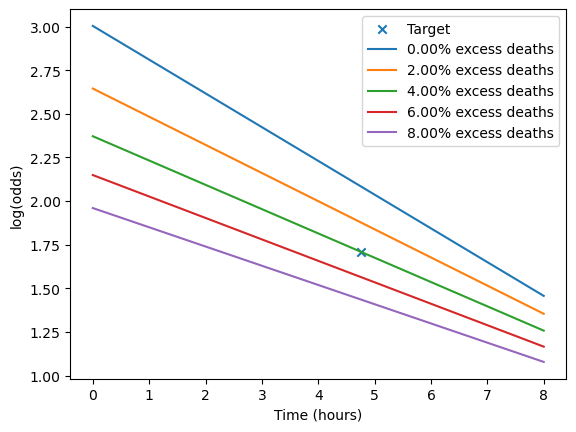

In [13]:
plt.scatter(t_target, l_target, label='Target', marker='x')
for ed in np.arange(0.00, 0.10, 0.02):
    # Find endpoints of the straight line for this excess deaths value:
    l_t0, l_tne = calculate_logodds_with_excess_deaths(p_pre, p_not, ed)
    # Plot the straight line fit:
    plt.plot(
        [t0, tne],
        [l_t0, l_tne],
        label=f'{ed:.2%} excess deaths'
    )
plt.legend()
plt.ylabel('log(odds)')
plt.xlabel('Time (hours)')
plt.show()

## Optimize the value of "excess deaths"

In [14]:
def calculate_difference_logodds_t_target(ed, args):
    l_t_target = calculate_logodds_t_target(ed, *args[1:])
    return np.abs(args[0] - l_t_target)

In [15]:
from scipy.optimize import minimize

In [16]:
results = minimize(
    calculate_difference_logodds_t_target,  # Result from this func.
    0.03,                                    # Initial guess.
    # args = [p_pre, p_not, tne, t0, t_target],  # Constants.
    args = [l_target, p_pre, p_not, tne, t0, t_target],  # Constants.
    method='Nelder-Mead'                    # Good when abs() in func.
)

# Save the optimized excess deaths value:
ed_opt = results.x[0]

# View full results:
results

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.00033718804324145424
             x: [ 4.003e-02]
           nit: 9
          nfev: 18
 final_simplex: (array([[ 4.003e-02],
                       [ 4.013e-02]]), array([ 3.372e-04,  3.890e-04]))

Check that this value is sensible by plotting its straight line fit:

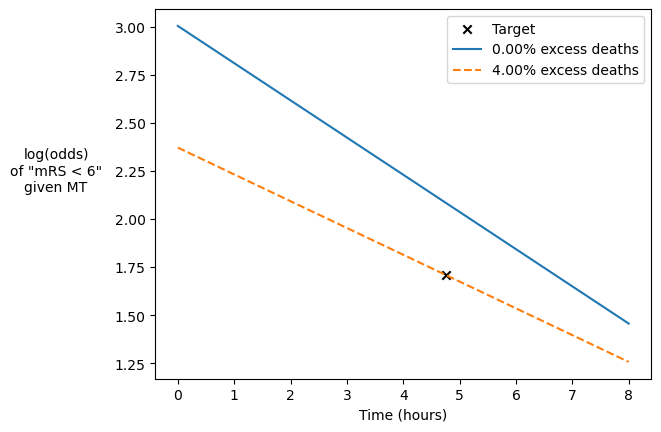

In [30]:
fig, ax = plt.subplots()
ax.scatter(t_target, l_target, label='Target', marker='x', color='k')

for e, ed in enumerate([0.00, ed_opt]):
    l_t0, l_tne = calculate_logodds_with_excess_deaths(p_pre, p_not, ed)
    plt.plot(
        [t0, tne],
        [l_t0, l_tne],
        label=f'{ed:.2%} excess deaths',
        linestyle='-' * (e + 1)
    )

# l_t_target_opt = calculate_logodds_t_target(ed_opt)
# plt.scatter(t_target, l_t_target_opt, marker='x', color='k')
ax.set_ylabel('log(odds)\nof "mRS < 6"\ngiven MT', rotation=0)
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.set_xlabel('Time (hours)')
plt.legend()
plt.savefig('./images/excess_deaths_mt_fit.png', bbox_inches='tight')
plt.show()